# Predicting Car Prices

Using data from [UCI Machine Learning](https://archive.ics.uci.edu/ml/datasets/automobile), we will build a model to predict car prices. The data was originally focused on assigning insurance ratings of riskiness and the associated losses resulted with that car model. 

In [1]:
# Import and perform preliminary inspection of data
import pandas as pd

# Make dataframe display human friendly
pd.options.display.max_columns = 25

# Assign correct column names
cols = ['symboling', 'normalized losses', 'make', 'fuel type', 
        'aspiration', 'num of doors', 'body style', 
        'drive wheels', 'engine location', 'wheel base', 
        'length', 'width', 'height', 'curb weight', 'engine type',
        'num of cylinders', 'engine size', 'fuel system', 'bore',
        'stroke', 'compression rate', 'horsepower', 'peak rpm',
        'city mpg', 'highway mpg', 'price']
car_data = pd.read_csv("imports-85.data", names = cols)
car_data.head(3)

,symboling,normalized losses,make,fuel type,aspiration,num of doors,body style,drive wheels,engine location,wheel base,length,width,...,engine type,num of cylinders,engine size,fuel system,bore,stroke,compression rate,horsepower,peak rpm,city mpg,highway mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500


In [2]:
# We are interested in only the numeric columns for predicting car prices
# Let's slice the dataframe to just these columns
numeric_cols = ["normalized losses","wheel base","length","width",
                "height", "curb weight", "engine size", "bore",
                "stroke", "compression rate", "horsepower",
                "peak rpm","city mpg",  "highway mpg", "price"]
car_data = car_data[numeric_cols]

# Quick glance at data frame contents
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
normalized losses    205 non-null object
wheel base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb weight          205 non-null int64
engine size          205 non-null int64
bore                 205 non-null object
stroke               205 non-null object
compression rate     205 non-null float64
horsepower           205 non-null object
peak rpm             205 non-null object
city mpg             205 non-null int64
highway mpg          205 non-null int64
price                205 non-null object
dtypes: float64(5), int64(4), object(6)
memory usage: 24.1+ KB


In [3]:
# Replace missing values with NaN for cleaning ease
import numpy as np
car_data = car_data.replace("?", np.nan)

# Reassigning the numeric columns to float type so they're easier to work with
car_data = car_data.astype(float)
# Confirm transformation
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
normalized losses    164 non-null float64
wheel base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb weight          205 non-null float64
engine size          205 non-null float64
bore                 201 non-null float64
stroke               201 non-null float64
compression rate     205 non-null float64
horsepower           203 non-null float64
peak rpm             203 non-null float64
city mpg             205 non-null float64
highway mpg          205 non-null float64
price                201 non-null float64
dtypes: float64(15)
memory usage: 24.1 KB


In [4]:
# Counting missing values
car_data.isnull().sum()

normalized losses    41
wheel base            0
length                0
width                 0
height                0
curb weight           0
engine size           0
bore                  4
stroke                4
compression rate      0
horsepower            2
peak rpm              2
city mpg              0
highway mpg           0
price                 4
dtype: int64

The normalized losses column has the most missing values out of any field (almost 25% of the entire data set). It would be unwise to drop that many rows. Since the normalized losses column is specific to insurance policies, not the price a manufacturer sets on a car, let's create a copy data frame without this column.

In [5]:
# Drop "normalized losses" column
car_data = car_data.drop("normalized losses", axis=1)

# Since price is the field we want to predict, drop rows missing
# this value so that we do not unnecessarily alter the model
car_data = car_data.dropna(subset=["price"])
car_data.isnull().sum()

wheel base          0
length              0
width               0
height              0
curb weight         0
engine size         0
bore                4
stroke              4
compression rate    0
horsepower          2
peak rpm            2
city mpg            0
highway mpg         0
price               0
dtype: int64

Since only six rows are left missing, roughly 3% of the total rows, we can safely fill these missing values with the mean values from the column without worrying about a large impact on the results of our model. 

In [6]:
# Fill missing values with mean 
car_data = car_data.fillna(car_data.mean())
# Confirm no missing values
car_data.isnull().sum()

wheel base          0
length              0
width               0
height              0
curb weight         0
engine size         0
bore                0
stroke              0
compression rate    0
horsepower          0
peak rpm            0
city mpg            0
highway mpg         0
price               0
dtype: int64

In [7]:
# Normalize columns to range of 0 to 1
price_col = car_data["price"]
normalized_car_data =(car_data - car_data.min())/(car_data.max() - car_data.min())
normalized_car_data["price"] = price_col

# Training and Testing models

The first model to test is a univariate KNN regression, using RMSE as the error metric.

In [8]:
# Creating a KNearestNeighbors function
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(train_col, target_col, df):
    model = KNeighborsRegressor()
    np.random.seed(1)
    
    # Randomize order of rows in data frame
    shuffled_index = np.random.permutation(df.index)
    df = df.reindex(shuffled_index)
    
    # Split; take 70% for training and 30% testing
    cutoff = int(len(df)*.7)
    train_set = df.iloc[0:cutoff]
    test_set = df.iloc[cutoff:]
    
    # Fit a KNN model on the data
    model.fit(train_set[[train_col]], train_set[target_col])
    
    # Make predictions on the test data
    predictions = model.predict(test_set[[train_col]])
    
    # Calculate and return RMSE
    mse = mean_squared_error(test_set[target_col], predictions)
    return np.sqrt(mse)

# Testing univariate models to find the best training column
train_cols = ["wheel base", "length",
              "width", "height", "curb weight", "engine size",
              "bore", "stroke", "compression rate", "horsepower",
              "peak rpm","city mpg",  "highway mpg"]

univariate_rmse_results = {}
for col in train_cols:
    rmse = knn_train_test(col, "price", normalized_car_data)
    univariate_rmse_results[col] = int(rmse)

In [9]:
# Sorting the values for easier analysis
univariate_rmse_series = pd.Series(univariate_rmse_results)
sorted_univariate_rmses = univariate_rmse_series.sort_values()
sorted_univariate_rmses

engine size         2871
city mpg            3773
horsepower          4465
curb weight         4533
width               4713
wheel base          4911
highway mpg         5138
length              5152
compression rate    6285
stroke              6813
peak rpm            7284
height              7537
bore                7626
dtype: int64

The features resulting in the three lowest RMSEs for a univariate KNeighborsRegression are "engine size", "city mpg", and "horsepower". Next, let's adjust the function to accept tuning of hyperparameter k to see if we can lower the RMSEs.

1    3
3    0
5    4
7    3
9    3
dtype: int64


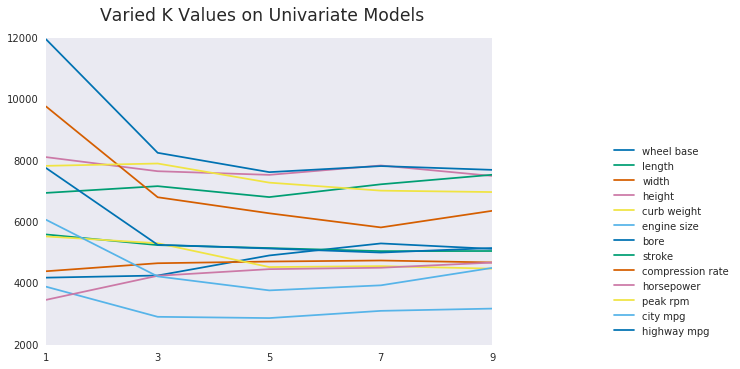

In [10]:
# Modifying the knn function to accept k as a parameter
def knn_train_test(train_col, target_col, df, k):
    model = KNeighborsRegressor(n_neighbors = k)
    np.random.seed(1)
    
    # Randomize order of rows in data frame
    shuffled_index = np.random.permutation(df.index)
    df = df.reindex(shuffled_index)
    
    # Split; take 70% for training and 30% testing
    cutoff = int(len(df)*.7)
    train_set = df.iloc[0:cutoff]
    test_set = df.iloc[cutoff:]
    
    # Fit a KNN model on the data
    model.fit(train_set[[train_col]], train_set[target_col])
    
    # Make predictions on the test data
    predictions = model.predict(test_set[[train_col]])
    
    # Calculate and return RMSE
    mse = mean_squared_error(test_set[target_col], predictions)
    return int(np.sqrt(mse))


# Inspect column to determine next steps
import matplotlib.pyplot as plt
%matplotlib inline


# Import seaborn for styling options
import seaborn as sns
CB_color_cycle = sns.color_palette(palette='colorblind')
plt.style.use('seaborn-colorblind')

# Various K values to test
k_vals = [1,3,5,7,9]
min_rmse_k_val = {1:0,3:0,5:0,7:0,9:0}
#plt.figure(figsize=(13,16))
for i, col in enumerate(train_cols):
    multivariate_results = {1:0,3:0,5:0,7:0,9:0}
    for kval in k_vals:
        multivariate_results[kval] = knn_train_test(col, "price", normalized_car_data, kval)
        sorted_results = pd.Series(multivariate_results).sort_index(inplace=False)
    x = list(sorted_results.index)
    y = list(sorted_results.iloc[0:6])
    #print(col, len(x), len(y))
    plt.plot(x,y,label=col)
    ymin = min(y)
    xpos = x[y.index(ymin)]
    #plt.annotate(int(min(y)), xy=(xpos-.5,ymin+100))
    min_rmse_k_val[xpos] += 1
plt.xticks(k_vals)

plt.suptitle("Varied K Values on Univariate Models",fontsize='x-large')
plt.grid(False)
plt.legend(loc=4,bbox_to_anchor=(1.55,0))
sns.despine()
print(pd.Series(min_rmse_k_val).sort_index(inplace=False))

The analysis above shows that a K value of 5 most often resulted in the lowest RMSE for univariate regressions. That being said, K values of 1, 7, and 9 were all one count shy of achieving the same performance. 

In [11]:
# Returning to first variation of model with default k value of 5
def knn_train_test(train_cols, target_col, df):
    model = KNeighborsRegressor()
    np.random.seed(1)
    
    # Randomize order of rows in data frame
    shuffled_index = np.random.permutation(df.index)
    df = df.reindex(shuffled_index)
    
    # Split; take 70% for training and 30% testing
    cutoff = int(len(df)*.7)
    train_set = df.iloc[0:cutoff]
    test_set = df.iloc[cutoff:]
    
    # Fit a KNN model on the data
    model.fit(train_set[train_cols], train_set[target_col])
    
    # Make predictions on the test data
    predictions = model.predict(test_set[train_cols])
    
    # Calculate and return RMSE
    mse = mean_squared_error(test_set[target_col], predictions)
    return int(np.sqrt(mse))

multivariate_results = {}

# Best features are determined by results of our univariate test
# Test best 2-5 features
for i in range(2,6):
    multivariate_results['{} best features:'.format(i)] = knn_train_test(
        sorted_univariate_rmses[:i].index,"price",normalized_car_data)

multivariate_results

{'2 best features:': 2884,
 '3 best features:': 2944,
 '4 best features:': 3230,
 '5 best features:': 3566}

The results of this multivariate test, with a k value of five, show that a multivariate regression with the two best features, results in slightly more variance than the univariate regression with the top feature "engine size".

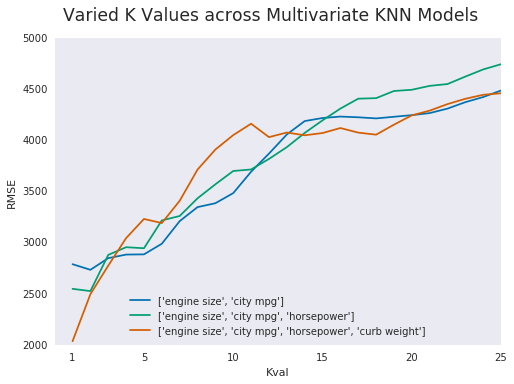

In [16]:
# Goal is to try K values 1-25 for the top 3 models
def knn_train_test(train_cols, target_col, df, k):
    model = KNeighborsRegressor(n_neighbors = k)
    np.random.seed(1)
    
    # Randomize order of rows in data frame
    shuffled_index = np.random.permutation(df.index)
    df = df.reindex(shuffled_index)
    
    # Split; take 70% for training and 30% testing
    cutoff = int(len(df)*.7)
    train_set = df.iloc[0:cutoff]
    test_set = df.iloc[cutoff:]
    
    # Fit a KNN model on the data
    model.fit(train_set[train_cols], train_set[target_col])
    
    # Make predictions on the test data
    predictions = model.predict(test_set[train_cols])
    
    # Calculate and return RMSE
    mse = mean_squared_error(test_set[target_col], predictions)
    return int(np.sqrt(mse))

multivariate_results = {}
top_3 = [["engine size","city mpg"],
         ["engine size","city mpg","horsepower"],
         ["engine size","city mpg","horsepower","curb weight"]
        ]

# Various K values to test
k_vals = list(range(1,26))
for i,model in enumerate(top_3):
    multivariate_results = {}
    for kval in k_vals:
        multivariate_results[kval] = knn_train_test(model, "price", normalized_car_data, kval)
    x = list(multivariate_results.keys())
    y = list(multivariate_results.values())
    plt.plot(x,y,label=model,color=CB_color_cycle[i])
plt.xticks([1,5,10,15,20,25])
plt.xlabel("Kval")
plt.ylabel("RMSE")
plt.legend(loc='lower center')
plt.suptitle("Varied K Values across Multivariate KNN Models",fontsize='x-large')
plt.grid(False)
sns.despine()

Of the models tested, the test resulting in the lowest RMSE was with the top 4 features and a k value of 1. The optimal k value decreased as we increased the number of features. This is likely due to the model having more similar comparisons available and a smaller k value results in more accurate predictions. 

The model can be further refined by implementing cross validation to reduce bias on a subset of training data.

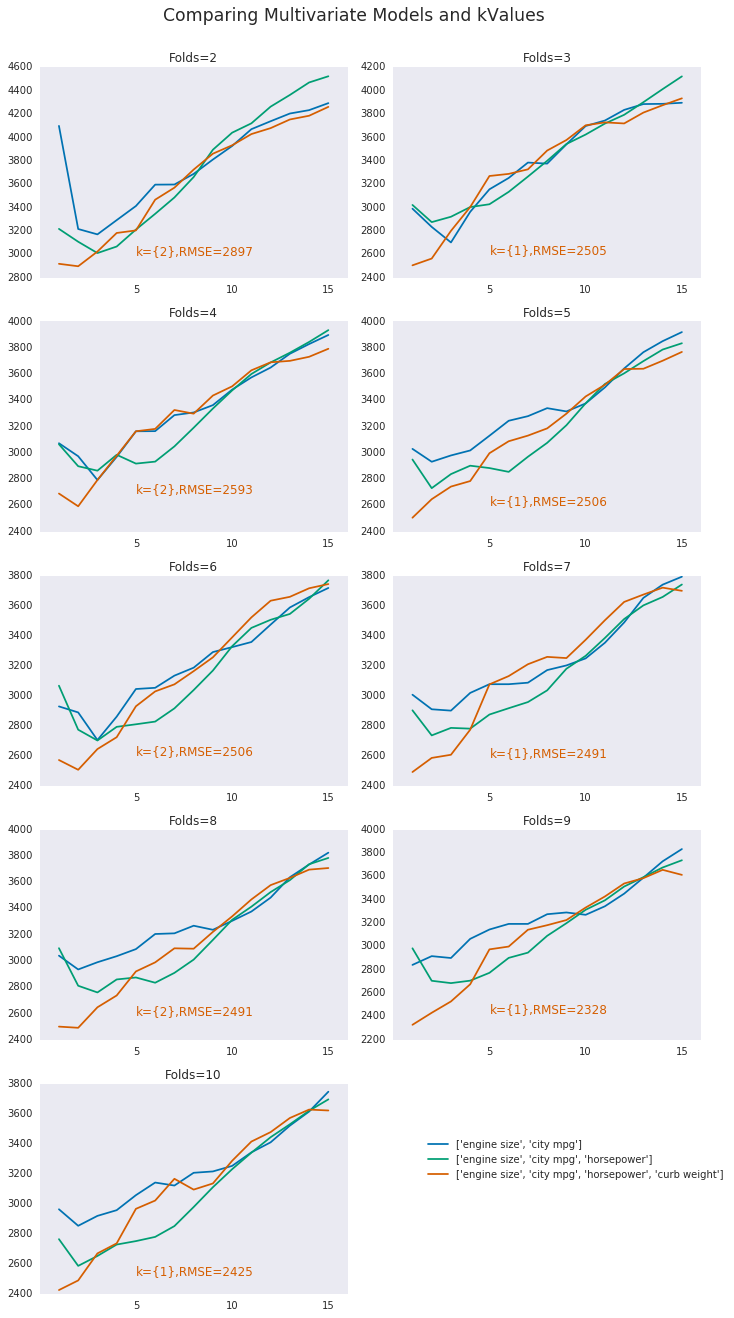

In [13]:
from sklearn.model_selection import cross_val_score, KFold


# Modify function to return the model class
def knn_train_test(train_cols, target_col, df, k):
    model = KNeighborsRegressor(n_neighbors = k)
    np.random.seed(1)
    
    # Randomize order of rows in data frame
    shuffled_index = np.random.permutation(df.index)
    df = df.reindex(shuffled_index)
    
    # Split; take 70% for training and 30% testing
    cutoff = int(len(df)*.7)
    train_set = df.iloc[0:cutoff]
    test_set = df.iloc[cutoff:]
    
    # Fit a KNN model on the data
    model.fit(train_set[train_cols], train_set[target_col])
    
    return model

plt.figure(figsize=(10,45))

# Run different cross validations with different k values and feature columns
for fold in range(2,11):
    kf = KFold(fold, shuffle=True, random_state=1)
    multivariate_results = {}
    min_y_val = 0
    plt.subplot(12,2,fold-1)
    for i,model in enumerate(top_3):
        multivariate_results[str(model)] = {}
        for k_val in range(1,16):
            mses = cross_val_score(knn_train_test(model,"price",normalized_car_data,k=k_val),
                                   normalized_car_data[model],normalized_car_data["price"],
                                   scoring="neg_mean_squared_error",cv=kf)
            rmses = np.sqrt(np.absolute(mses))
            avg_rmse = round(np.mean(rmses))
            multivariate_results[str(model)][k_val] = avg_rmse
        x = list(multivariate_results[str(model)].keys())
        y = list(multivariate_results[str(model)].values())
        plt.plot(x,y,color=CB_color_cycle[i])
        if min_y_val == 0:
            min_y_val = min(y)
            min_model = i
            min_k = 2
        else:
            if min(y) < min_y_val:
                min_y_val = min(y)
                min_model = i
                min_k = {n for n in multivariate_results[str(top_3[i])] if multivariate_results[str(top_3[i])][n]==min_y_val}
    plt.xticks([5,10,15])
    plt.title("Folds="+str(fold))
    plt.grid(False)
    plt.annotate(("k="+str(min_k)+",RMSE="+str(int(min_y_val))), xy=(5,(min_y_val+100)),color=CB_color_cycle[i])
plt.suptitle("Comparing Multivariate Models and kValues",fontsize='x-large')
plt.legend(top_3,loc=4,bbox_to_anchor=(2.25,.5))
plt.tight_layout(rect=[0, 0.03, 1, .97])
sns.despine()

# Conclusion

After adding KFold validation to our model selection process, we find that the model resulting in the lowest average RMSE uses the top 4 feature columns, 9 folds, and a k value of 1. Given the availability of input data, this is the best model to use for predicting car prices from 1985.

# Lessons learned from this project

Don't use inplace=True. This results in inconsistent and sometimes unreliable processes behind the scenes

Instead of trying to sort a dictionary, turn it into a pd.series and sort that.

If all the googling in the world isn't fixing your problem, pore over every single syntax possibility to make sure that the code is correct (missing brackets or commas, incorrect object type, etc.)